<a href="https://colab.research.google.com/github/MarcosVeniciu/Inception_V1/blob/main/Inception_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Artigo: https://ai.plainenglish.io/googlenet-inceptionv1-with-tensorflow-9e7f3a161e87
# Codigo de referencia: https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v1.py
# Outras referencias de codigo: https://paperswithcode.com/paper/going-deeper-with-convolutions

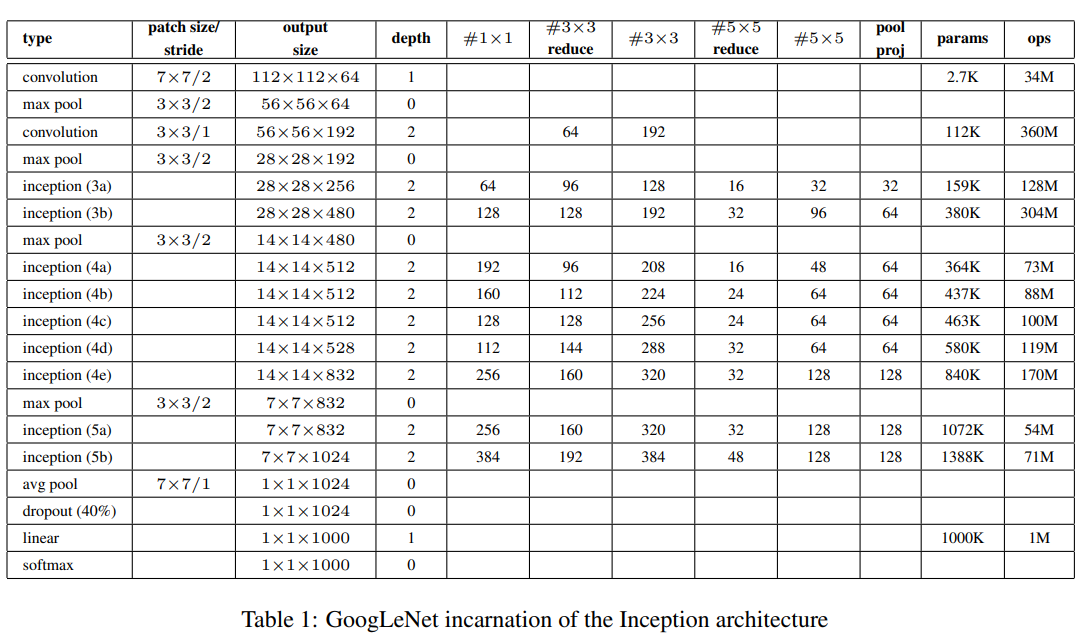

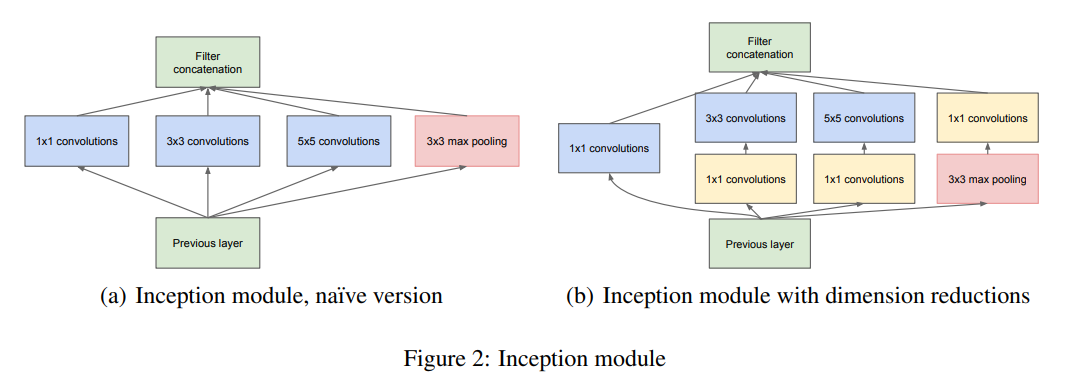

In [1]:
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
import tensorflow as tf

print(tf.__version__) # 2.12.0 (12/5/2023)

2.12.0


In [3]:
image_size = (224, 224)
input_shape = image_size + (1,)
num_classes = 10

# Dataset

In [4]:
import numpy as np
import cv2
from keras.utils import np_utils
# Preparing the Dataset

num_classes = 10
img_rows,img_cols = 224, 224

# Load training and validation sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Resize images to 244x244
X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:][:3000]])
X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:,:,:,:][:3000]])
y_train = y_train[:3000]
y_test = y_test[:3000]

# Transform targets to keras compatible format
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Making all the values range between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, y_train.shape, X_test.shape, y_test.shape

11490434/11490434 [==============================] - 0s 0us/step


((3000, 224, 224), (3000, 10), (3000, 224, 224), (3000, 10))

# Modelo

In [5]:
# Ob1: No artigo na primeira camada conv é 1x1 e na segunda é 5x5, no codigo é 1x1, e depois 3x3. MANTIVE O DO ARTIGO
# Ob2: No codigo de referencia foi usado axis=3. Mantive o do código.
# Ob3: A saida da Conv é 4, 4, 128, então usie uma camada Flatten pra transformar isso em um vetor

## Blocos

In [6]:
def inception_3a(previous_layer):
  branch_0 = layers.Conv2D(filters=64, kernel_size = [1,1], padding='same', activation='relu', name='Inception_3a_Conv_1x1')(previous_layer)
  
  branch_1 = layers.Conv2D(filters=96, kernel_size = [1,1], padding='same', activation='relu', name='Inception_3a_Conv_3x3_reduce')(previous_layer)
  branch_1 = layers.Conv2D(filters=128, kernel_size = [3,3], padding='same', activation='relu', name='Inception_3a_Conv_3x3')(branch_1)

  branch_2 = layers.Conv2D(filters=16, kernel_size = [1,1], padding='same', activation='relu', name='Inception_3a_Conv_5x5_reduce')(previous_layer)
  branch_2 = layers.Conv2D(filters=32, kernel_size = [5,5], padding='same', activation='relu', name='Inception_3a_Conv_5x5')(branch_2) # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_3a_MaxPool_3x3')(previous_layer)
  branch_3 = layers.Conv2D(filters=32, kernel_size = [1,1], padding='same', activation='relu', name='Inception_3a_Conv_1x1_pool_porj')(branch_3)

  # Concat
  return tf.concat(values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_3a') # Ob2



def inception_3b(previous_layer):
  branch_0 = layers.Conv2D(filters=128, kernel_size = [1,1], padding='same', activation='relu', name='Inception_3b_Conv_1x1')(previous_layer)
  
  branch_1 = layers.Conv2D(filters=128, kernel_size = [1,1], padding='same', activation='relu', name='Inception_3b_Conv_3x3_reduce')(previous_layer)
  branch_1 = layers.Conv2D(filters=192, kernel_size = [3,3], padding='same', activation='relu', name='Inception_3b_Conv_3x3')(branch_1)

  branch_2 = layers.Conv2D(filters=32, kernel_size = [1,1], padding='same', activation='relu', name='Inception_3b_Conv_5x5_reduce')(previous_layer)
  branch_2 = layers.Conv2D(filters=96, kernel_size = [5,5], padding='same', activation='relu', name='Inception_3b_Conv_5x5')(branch_2) # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_3b_MaxPool_3x3')(previous_layer)
  branch_3 = layers.Conv2D(filters=64, kernel_size = [1,1], padding='same', activation='relu', name='Inception_3b_Conv_1x1_pool_porj')(branch_3)

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_3b') # Ob2

In [7]:
def inception_4a(previous_layer):
  branch_0 = layers.Conv2D(filters=192, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4a_Conv_1x1')(previous_layer)
  
  branch_1 = layers.Conv2D(filters=96, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4a_Conv_3x3_reduce')(previous_layer)
  branch_1 = layers.Conv2D(filters=208, kernel_size = [3,3], padding='same', activation='relu', name='Inception_4a_Conv_3x3')(branch_1)

  branch_2 = layers.Conv2D(filters=16, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4a_Conv_5x5_reduce')(previous_layer)
  branch_2 = layers.Conv2D(filters=48, kernel_size = [5,5], padding='same', activation='relu', name='Inception_4a_Conv_5x5')(branch_2) # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4a_MaxPool_3x3')(previous_layer)
  branch_3 = layers.Conv2D(filters=64, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4a_Conv_1x1_pool_porj')(branch_3)

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4a') # Ob2



def inception_4b(previous_layer):
  branch_0 = layers.Conv2D(filters=160, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4b_Conv_1x1')(previous_layer)
  
  branch_1 = layers.Conv2D(filters=112, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4b_Conv_3x3_reduce')(previous_layer)
  branch_1 = layers.Conv2D(filters=224, kernel_size = [3,3], padding='same', activation='relu', name='Inception_4b_Conv_3x3')(branch_1)

  branch_2 = layers.Conv2D(filters=24, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4b_Conv_5x5_reduce')(previous_layer)
  branch_2 = layers.Conv2D(filters=64, kernel_size = [5,5], padding='same', activation='relu', name='Inception_4b_Conv_5x5')(branch_2) # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4b_MaxPool_3x3')(previous_layer)
  branch_3 = layers.Conv2D(filters=64, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4b_Conv_1x1_pool_porj')(branch_3)

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4b') # Ob2



def inception_4c(previous_layer):
  branch_0 = layers.Conv2D(filters=128, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4c_Conv_1x1')(previous_layer)
  
  branch_1 = layers.Conv2D(filters=128, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4c_Conv_3x3_reduce')(previous_layer)
  branch_1 = layers.Conv2D(filters=256, kernel_size = [3,3], padding='same', activation='relu', name='Inception_4c_Conv_3x3')(branch_1)

  branch_2 = layers.Conv2D(filters=24, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4c_Conv_5x5_reduce')(previous_layer)
  branch_2 = layers.Conv2D(filters=64, kernel_size = [5,5], padding='same', activation='relu', name='Inception_4c_Conv_5x5')(branch_2) # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4c_MaxPool_3x3')(previous_layer)
  branch_3 = layers.Conv2D(filters=64, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4c_Conv_1x1_pool_porj')(branch_3)

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4c') # Ob2



def inception_4d(previous_layer):
  branch_0 = layers.Conv2D(filters=112, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4d_Conv_1x1')(previous_layer)
  
  branch_1 = layers.Conv2D(filters=144, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4d_Conv_3x3_reduce')(previous_layer)
  branch_1 = layers.Conv2D(filters=288, kernel_size = [3,3], padding='same', activation='relu', name='Inception_4d_Conv_3x3')(branch_1)

  branch_2 = layers.Conv2D(filters=32, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4d_Conv_5x5_reduce')(previous_layer)
  branch_2 = layers.Conv2D(filters=64, kernel_size = [5,5], padding='same', activation='relu', name='Inception_4d_Conv_5x5')(branch_2) # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4d_MaxPool_3x3')(previous_layer)
  branch_3 = layers.Conv2D(filters=64, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4d_Conv_1x1_pool_porj')(branch_3)

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4d') # Ob2

def inception_4e(previous_layer):
  branch_0 = layers.Conv2D(filters=256, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4e_Conv_1x1')(previous_layer)
  
  branch_1 = layers.Conv2D(filters=160, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4e_Conv_3x3_reduce')(previous_layer)
  branch_1 = layers.Conv2D(filters=320, kernel_size = [3,3], padding='same', activation='relu', name='Inception_4e_Conv_3x3')(branch_1)

  branch_2 = layers.Conv2D(filters=32, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4e_Conv_5x5_reduce')(previous_layer)
  branch_2 = layers.Conv2D(filters=128, kernel_size = [5,5], padding='same', activation='relu', name='Inception_4e_Conv_5x5')(branch_2) # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4e_MaxPool_3x3')(previous_layer)
  branch_3 = layers.Conv2D(filters=128, kernel_size = [1,1], padding='same', activation='relu', name='Inception_4e_Conv_1x1_pool_porj')(branch_3)

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4e') # Ob2

In [8]:
def inception_5a(previous_layer):
  branch_0 = layers.Conv2D(filters=256, kernel_size = [1,1], padding='same', activation='relu', name='Inception_5a_Conv_1x1')(previous_layer)
  
  branch_1 = layers.Conv2D(filters=160, kernel_size = [1,1], padding='same', activation='relu', name='Inception_5a_Conv_3x3_reduce')(previous_layer)
  branch_1 = layers.Conv2D(filters=320, kernel_size = [3,3], padding='same', activation='relu', name='Inception_5a_Conv_3x3')(branch_1)

  branch_2 = layers.Conv2D(filters=32, kernel_size = [1,1], padding='same', activation='relu', name='Inception_5a_Conv_5x5_reduce')(previous_layer)
  branch_2 = layers.Conv2D(filters=128, kernel_size = [5,5], padding='same', activation='relu', name='Inception_5a_Conv_5x5')(branch_2) # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_5a_MaxPool_3x3')(previous_layer)
  branch_3 = layers.Conv2D(filters=128, kernel_size = [1,1], padding='same', activation='relu', name='Inception_5a_Conv_1x1_pool_porj')(branch_3)

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_5a') # Ob2



def inception_5b(previous_layer):
  branch_0 = layers.Conv2D(filters=384, kernel_size = [1,1], padding='same', activation='relu', name='Inception_5b_Conv_1x1')(previous_layer)
  
  branch_1 = layers.Conv2D(filters=192, kernel_size = [1,1], padding='same', activation='relu', name='Inception_5b_Conv_3x3_reduce')(previous_layer)
  branch_1 = layers.Conv2D(filters=384, kernel_size = [3,3], padding='same', activation='relu', name='Inception_5b_Conv_3x3')(branch_1)

  branch_2 = layers.Conv2D(filters=48, kernel_size = [1,1], padding='same', activation='relu', name='Inception_5b_Conv_5x5_reduce')(previous_layer)
  branch_2 = layers.Conv2D(filters=128, kernel_size = [5,5], padding='same', activation='relu', name='Inception_5b_Conv_5x5')(branch_2) # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_5b_MaxPool_3x3')(previous_layer)
  branch_3 = layers.Conv2D(filters=128, kernel_size = [1,1], padding='same', activation='relu', name='Inception_5b_Conv_1x1_pool_porj')(branch_3)

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_5b') # Ob2

## Rede

In [15]:
def inception_v1(input_shape, num_classes):
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  inputs = keras.Input(shape = input_shape)
  scale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)
  x = scale_layer(inputs)

  x = layers.Conv2D(filters=64, kernel_size = [7,7], strides=2, padding='same', activation='relu')(x)
  x = layers.MaxPool2D(pool_size = [3,3], strides=2, padding='same')(x)
  x = layers.Conv2D(filters=64, kernel_size = [1,1], strides=1, padding='same', activation='relu')(x)
  x = layers.Conv2D(filters=192, kernel_size = [3,3], strides=1, padding='same', activation='relu')(x)
  x = layers.MaxPool2D(pool_size = [3,3], strides=2, padding='same')(x)

  x = inception_3a(x)
  x = inception_3b(x)

  x = layers.MaxPool2D(pool_size = [3,3], strides=2, padding='same')(x)

  x = inception_4a(x)
  x = inception_4b(x)
  x = inception_4c(x)

  x = inception_4d(x)
  x = inception_4e(x)

  x = layers.MaxPool2D(pool_size = [3,3], strides=2, padding='same')(x)
  
  x = inception_5a(x)
  x = inception_5b(x)  

  x = keras.layers.AveragePooling2D(pool_size=(7, 7), strides=1, name="Olaha_eu")(x)
  x = keras.layers.Flatten()(x) #Obs3
  x = keras.layers.Dropout(rate = 0.4)(x)
  outputs = keras.layers.Dense(units, activation=activation, name="softmax_2")(x)

  return keras.Model(inputs, outputs, name="Inception_V1")

In [16]:
modelo_view = inception_v1(input_shape, num_classes)  

In [17]:
modelo_view.summary()

Model: "Inception_V1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 112, 112, 64  3200        ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                       

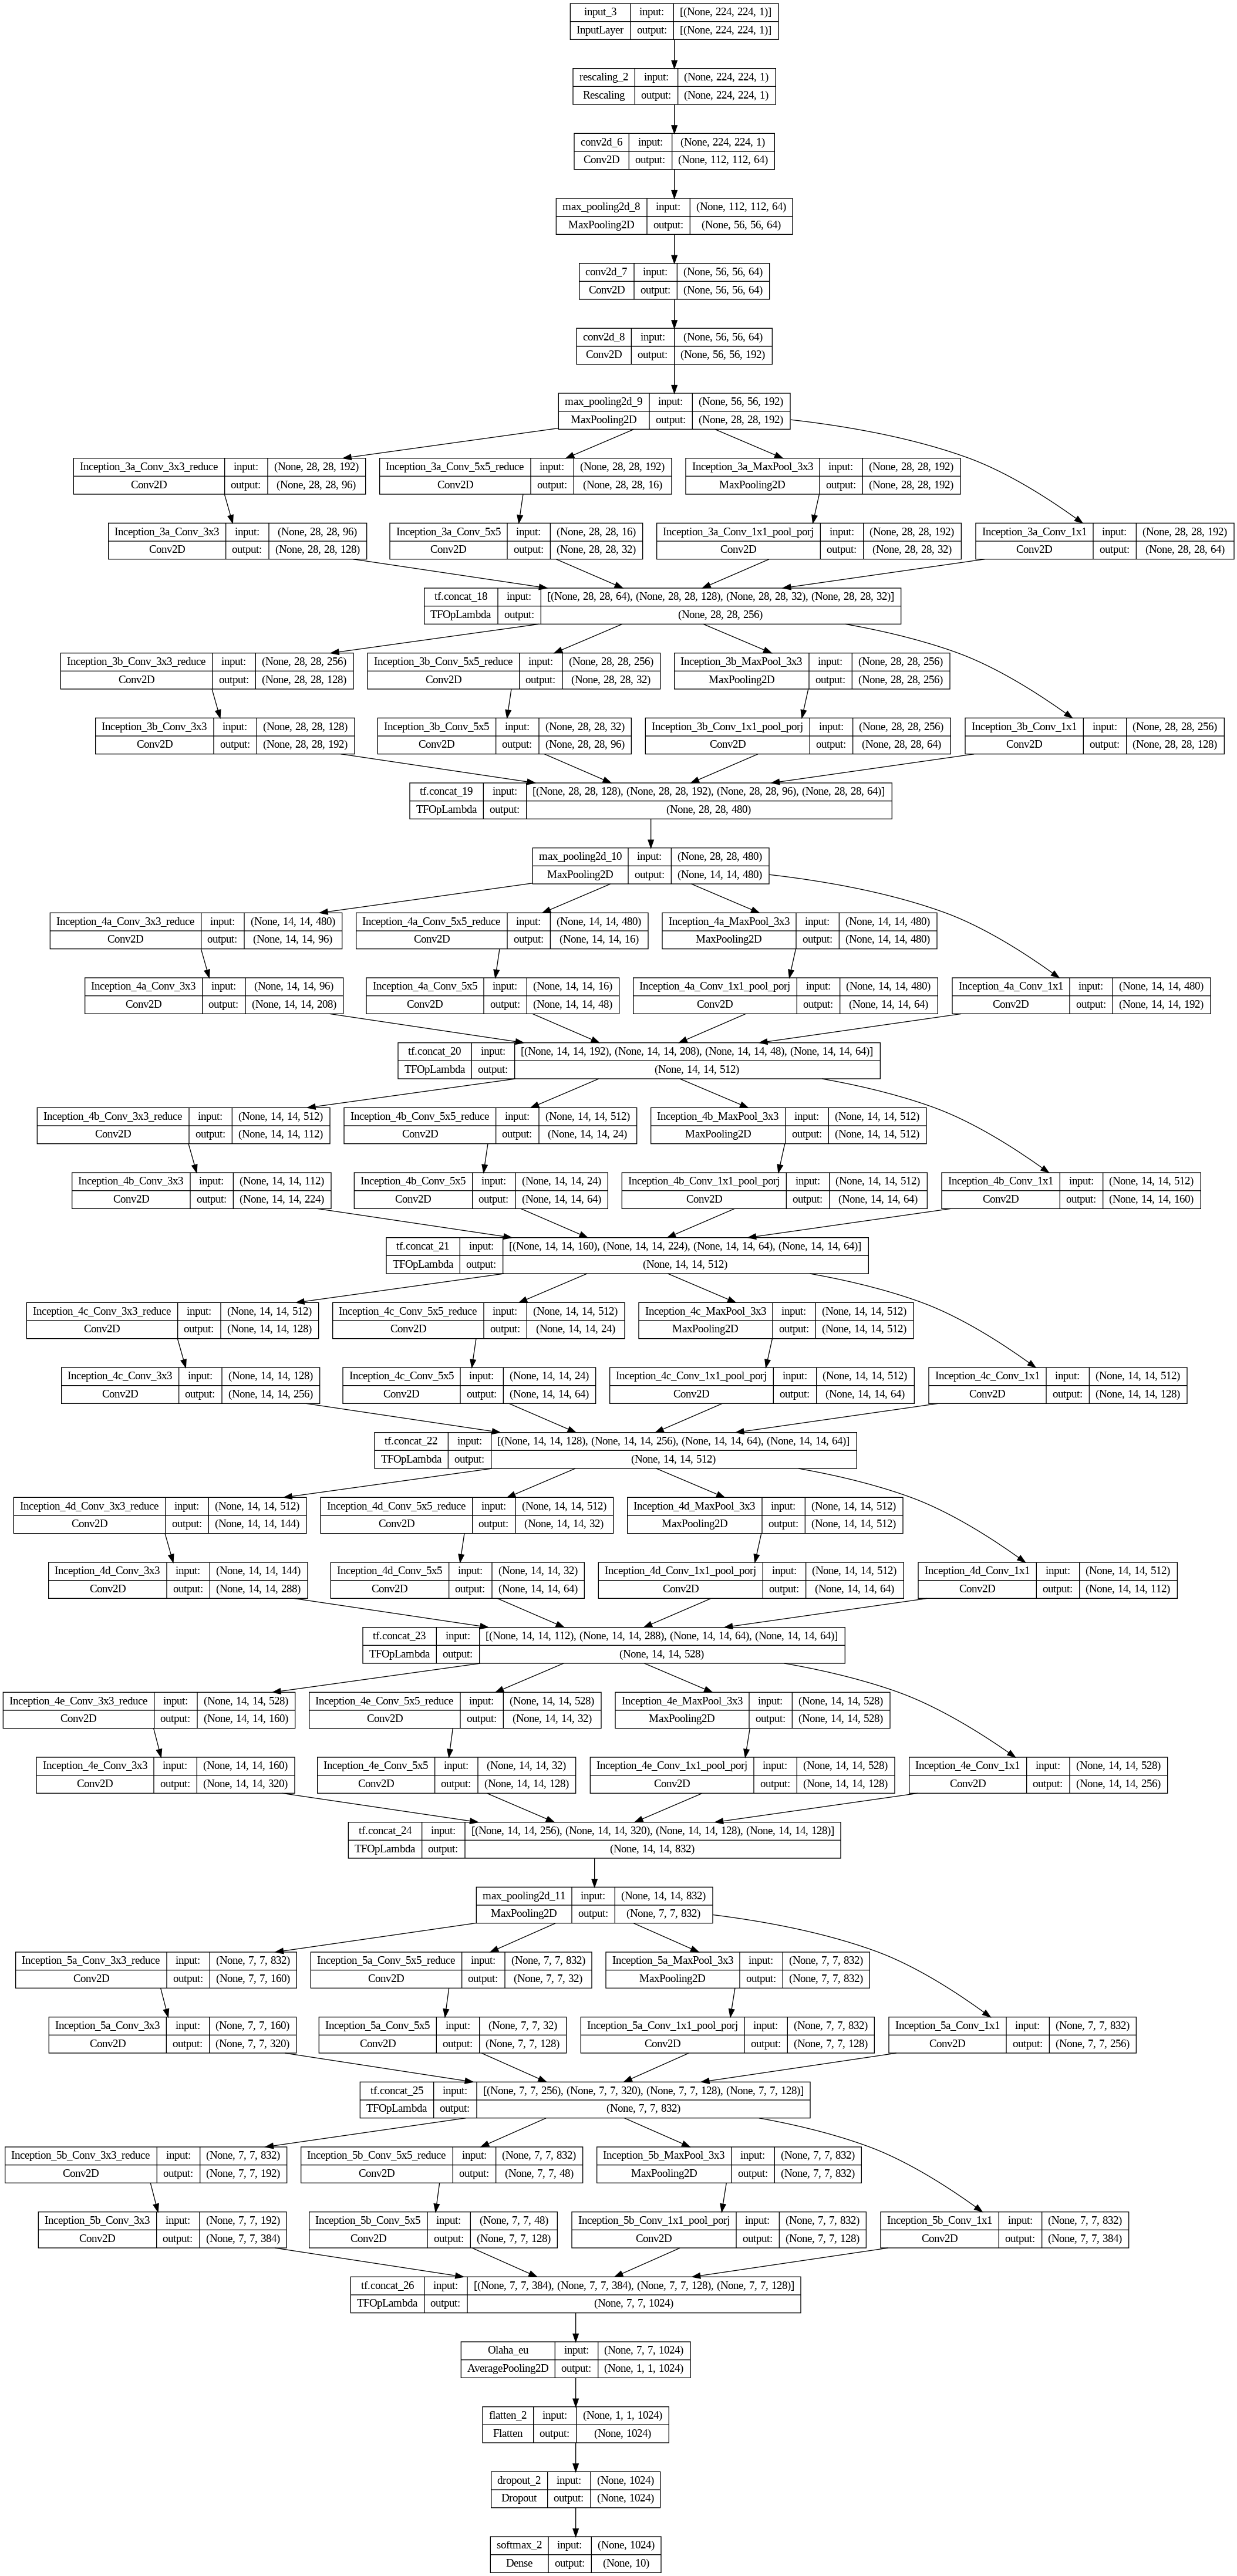

In [18]:
keras.utils.plot_model(modelo_view, show_shapes=True)

# Treinamento

In [19]:
model = inception_v1(input_shape, num_classes)  
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
              loss= ['categorical_crossentropy'],
              metrics=['accuracy'])

In [20]:
epocas = 10
!nvidia-smi
historico = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epocas, batch_size=256)

Thu May 18 01:24:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |   9117MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

KeyboardInterrupt: ignored